In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import analyze_utils

# inversion model: wandb.ai/jack-morris/emb-inv-1/runs/ebb31d91810c4b62d2b55b5382e8c7ea/logs?workspace=user-jxmorris12
# cross-encoder: wandb.ai/jack-morris/emb-rerank-1/runs/7bd186119e1f4f789eaa0731fd7357a1/overview?workspace=user-jxmorris12
checkpoint_folder = "/home/jxm3/research/retrieval/inversion/saves/98b1418d38c3f9333b17ab20bff06ff9/"

trainer = analyze_utils.load_trainer(checkpoint_folder)

Loading trainer for analysis – setting --do_eval=1
loading alias dpr_nq__msl32_beta from /home/jxm3/research/retrieval/inversion/saves/db66b9c01b644541fedbdcc59c53a285/ebb31d91810c4b62d2b55b5382e8c7ea...
Set train_args.dataloader_num_workers = 4


/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output -> The mlbies wase wyst bograge; And the sliths and toms wre
================ End trainer sanity check ================


In [3]:
eval_batch = next(iter(trainer.get_eval_dataloader()))
eval_batch = {k: v[None, 0] for k,v in eval_batch.items() } # take first item
eval_batch = {k: v.to(trainer.args.device) for k,v in eval_batch.items() } # put on GPU

In [8]:
import torch

model = trainer.inversion_trainer.model
tokenizer = model.embedder_tokenizer

N = 256

sampled_outputs = model.generate(
    inputs=eval_batch,
    generation_kwargs={
        "max_length": 32,
        "early_stopping": True,
        "do_sample": True,
        "top_p": 0.9,
        "temperature": 1.0,
        "num_return_sequences": N,
    },
)
eos_tokens = torch.ones((N, 1), dtype=torch.long, device=trainer.args.device) * tokenizer.eos_token_id
sampled_outputs = torch.cat((sampled_outputs, eos_tokens), dim=1)
sampled_outputs = sampled_outputs[:, 1:]

In [13]:
with torch.no_grad():
    original_embeddings = model.call_embedding_model(
        input_ids=eval_batch['embedder_input_ids'],
        attention_mask=eval_batch['embedder_attention_mask']
    )
    sampled_output_embeddings = model.call_embedding_model(
        input_ids=sampled_outputs,
        attention_mask=torch.ones_like(sampled_outputs, device=trainer.args.device),
    )
    original_embeddings /= original_embeddings.norm(p=2, dim=1, keepdim=True)
    sampled_output_embeddings /= sampled_output_embeddings.norm(p=2, dim=1, keepdim=True)
    
    sims = original_embeddings @ sampled_output_embeddings.T
    
    labels = sampled_outputs.contiguous()
    outputs = model(
        embedder_input_ids=eval_batch['embedder_input_ids'].repeat((N, 1)),
        embedder_attention_mask=eval_batch['embedder_attention_mask'].repeat((N, 1)),
        labels=labels,
        frozen_embeddings=None,
    )
    lm_logits = outputs.logits
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100,  reduce=False)
    likelihoods = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
    likelihoods = likelihoods.reshape((N, -1)).mean(-1)

In [14]:
likelihoods.shape, sims.shape

(torch.Size([256]), torch.Size([1, 256]))

In [28]:
original_text = tokenizer.batch_decode(eval_batch['input_ids'], skip_special_tokens=True)[0]
sampled_texts = tokenizer.batch_decode(sampled_outputs, skip_special_tokens=True)

In [29]:
sampled_texts[0], original_text

('to those of the skull of the infant, which are rather smooth and suture, even in those non-tural characters of suture. Consequently',
 'to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact')

In [30]:
bleu_score = lambda p, r: trainer.metric_bleu.compute(predictions=[p], references=[r])["score"]
bleus = [bleu_score(s, original_text) for s in sampled_texts]

Text(0, 0.5, 'cosine similarity')

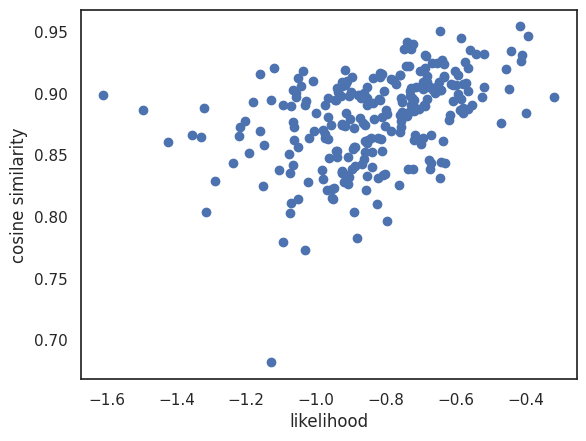

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

plt.scatter(x=-likelihoods.cpu(), y=sims.cpu())
plt.xlabel('likelihood')
plt.ylabel('cosine similarity')

Text(0, 0.5, 'bleu')

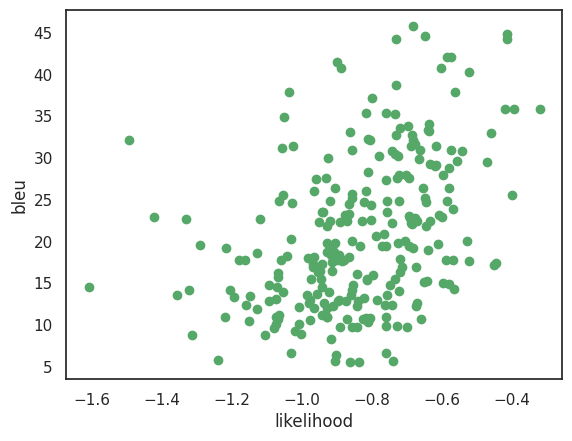

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

plt.scatter(x=-likelihoods.cpu(), y=bleus , color=sns.color_palette()[2])
plt.xlabel('likelihood')
plt.ylabel('bleu')

Text(0, 0.5, 'bleu')

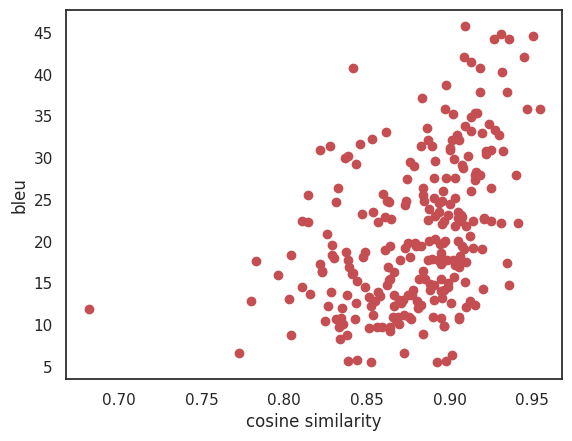

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

plt.scatter(x=sims.cpu(), y=bleus, color=sns.color_palette()[3])
plt.xlabel('cosine similarity')
plt.ylabel('bleu')